In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [4]:
%matplotlib inline

import itertools
from sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from scipy import stats
from scipy import signal
from skimage.segmentation import watershed, slic
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import decomposition
from population import unit_activity_matrix
from psth import get_psth_matrix
from spiketrain import smooth_gaussian, smooth_rectangular

from sessions_nMAP_EV_SU import selected

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

all_selected = []
for animal, s_list in selected.items():
    all_selected += s_list

all_selected[:7], len(all_selected)

(['009266_hippoSIT_2023-04-17_17-04-17',
  '009266_hippoSIT_2023-04-18_10-10-37',
  '009266_hippoSIT_2023-04-18_17-03-10',
  '009266_hippoSIT_2023-04-19_10-33-51',
  '009266_hippoSIT_2023-04-20_08-57-39',
  '009266_hippoSIT_2023-04-21_08-43-00',
  '009266_hippoSIT_2023-04-21_13-12-31'],
 65)

In [6]:
# manuscript session
session = '009266_hippoSIT_2023-04-18_10-10-37'

## Single session - playground

In [132]:
electrodes = [1, 2]

animal   = session.split('_')[0]
session_path = os.path.join(source, animal, session)
psth_file  = os.path.join(session_path, 'analysis', 'psth_micro.h5')
#nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_noconv.h5')
nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_with_PSTH.h5')
mose_file  = os.path.join(session_path, 'analysis', 'MoSeq_tSNE_UMAP.h5')
unit_file  = os.path.join(session_path, 'units.h5')
meta_file  = os.path.join(session_path, 'meta.h5')
desc_file  = os.path.join(session_path, 'descendants.h5')


with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    cfg = json.loads(f['processed'].attrs['parameters'])
with h5py.File(nmap_file, 'r') as f:
    response_manifold = np.array(f['response_manifold'])
    unit_mx_ev = np.array(f['unit_mx_proc_ev'])
    unit_mx_su = np.array(f['unit_mx_proc_su'])
with h5py.File(desc_file, 'r') as f:
    speed = np.array(f['speed'])
    hd    = np.array(f['hd'])
    
with h5py.File(mose_file, 'r') as f:
    syl_ratio_mx = np.array(f['syl_ratio_mx'])
    idxs_srm_tl = np.array(f['idxs_srm_tl'])
    
spike_times = {}
with h5py.File(unit_file, 'r') as f:
    unit_names = [x for x in f if int(x.split('-')[0]) in electrodes]
with h5py.File(unit_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name]['spike_times'])
        
session

'009266_hippoSIT_2023-04-18_10-10-37'

### 1. Unit AM

In [11]:
# compute activity matrix
bin_size = 0.01
latency  = cfg['sound']['latency']  # seconds
bins_per_event = int(latency / bin_size)
bins, unit_mx = unit_activity_matrix(meta_file, unit_file, electrodes, bin_size=bin_size)
    
# z-score
for i in range(len(unit_mx)):
    unit_mx[i] = stats.zscore(unit_mx[i])

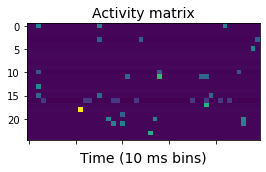

In [51]:
x_l, x_r = 30, 35  # in seconds

fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))

im = ax.imshow(unit_mx[:, x_l*100:x_r*100 - 450])
ax.set_xlabel('Time (10 ms bins)', fontsize=14)
ax.set_title('Activity matrix', fontsize=14)
ax.set_xticklabels([])
#ax.set_yticks(np.arange(1, unit_mx.shape[0], 5))
#ax.set_yticklabels(np.arange(unit_mx.shape[0]))

#divider = make_axes_locatable(ax)
#cax = divider.append_axes('right', size='5%', pad=0.05)
#fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_unit_mx.png' % session[-19:-6]), dpi=300)

### 2. PSTH evoked

In [52]:
psth_bins, psths_all = get_psth_matrix(psth_file, electrodes)
conditions = list(psths_all.keys())

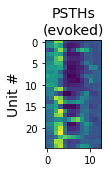

In [60]:
idx_s = int(psths_all[cond].shape[1]/2)
idx_e = idx_s + int(np.ceil(idx_s/2))

fig, ax = plt.subplots(1, 1, figsize=(2, 2.5))

ax.imshow(psths_all['BGR'][:, idx_s:idx_e])
ax.set_ylabel('Unit #', fontsize=14)
ax.set_title('PSTHs\n(evoked)', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_profile_mx.png' % session[-19:-6]), dpi=300)

### 3. example evoked / sustained matrices

In [64]:
x_l, x_r = 0, 8  # in seconds

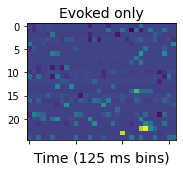

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))

ax.imshow(unit_mx_ev[x_l*4:x_r*4].T)
ax.set_xlabel('Time (125 ms bins)', fontsize=14)
ax.set_title('Evoked only', fontsize=14)
ax.set_xticklabels([])
#ax.set_ylabel('Units', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_evoked_mx.png' % session[-19:-6]), dpi=300)

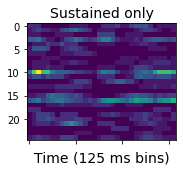

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))

ax.imshow(unit_mx_su[x_l*4:x_r*4].T)
ax.set_xlabel('Time (125 ms bins)', fontsize=14)
ax.set_title('Sustained only', fontsize=14)
ax.set_xticklabels([])
#ax.set_ylabel('Units', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_sustained_mx.png' % session[-19:-6]), dpi=300)

In [68]:
x_l, x_r = 0, 6
idxs_p = np.where((sound_events[:, 0] > x_l) & (sound_events[:, 0] < x_r))[0]

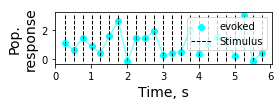

In [69]:
# selected for the manuscript
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))

#evoked_act = response_manifold[:, 0]
evoked_act = unit_mx_ev.sum(axis=1)/unit_mx_ev.shape[1]
idxs_p = np.where((sound_events[:, 0] > x_l) & (sound_events[:, 0] < x_r))[0]

ax.plot(sound_events[idxs_p][:, 0], evoked_act[idxs_p], color='cyan', alpha=0.5, lw=1.5)
ax.scatter(sound_events[idxs_p][:, 0], evoked_act[idxs_p], color='cyan', label='evoked')
ax.vlines(sound_events[idxs_p][:, 0], evoked_act[idxs_p].min(), evoked_act[idxs_p].max(), color='black', lw=1, ls='--', label='Stimulus')

ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Pop.\nresponse', fontsize=14)
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_evoked_response.png' % session[-19:-6]), dpi=300)

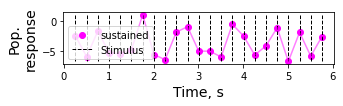

In [70]:
# selected for the manuscript
fig, ax = plt.subplots(1, 1, figsize=(5, 1.5))


su_pca = decomposition.PCA(n_components=2)
su_X   = su_pca.fit_transform(unit_mx_ev)
su_resp = su_X[:, 0]  # PC1 scores. bin_size resolution

ax.plot(sound_events[idxs_p][:, 0], su_resp[idxs_p], color='magenta', alpha=0.5, lw=1.5)
ax.scatter(sound_events[idxs_p][:, 0], su_resp[idxs_p], color='magenta', label='sustained')
ax.vlines(sound_events[idxs_p][:, 0], su_resp[idxs_p].min(), su_resp[idxs_p].max(), color='black', lw=1, ls='--', label='Stimulus')

ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Pop.\nresponse', fontsize=14)
ax.legend(loc='lower left')

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_sustained_response.png' % session[-19:-6]), dpi=300)

## Example traces

In [152]:
ev_min_idx = 200
ev_max_idx = 1000
t1 = ev_min_idx / 4
t2 = ev_max_idx / 4
step = 1  # sec

x_vals_all = np.arange(len(sound_events)) / 4
x_vals = x_vals_all[ev_min_idx:ev_max_idx]

# sound events
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]

idxs_sil_ev = idxs_sil_ev[(idxs_sil_ev > ev_min_idx) & (idxs_sil_ev < ev_max_idx)]
idxs_bgr_ev = idxs_bgr_ev[(idxs_bgr_ev > ev_min_idx) & (idxs_bgr_ev < ev_max_idx)]
idxs_tgt_ev = idxs_tgt_ev[(idxs_tgt_ev > ev_min_idx) & (idxs_tgt_ev < ev_max_idx)]

x_bgr = x_vals_all[idxs_bgr_ev]
x_tgt = x_vals_all[idxs_tgt_ev]

# EV / SU population responses
EV = response_manifold[ev_min_idx:ev_max_idx, 0]
SU = response_manifold[ev_min_idx:ev_max_idx, 1]

# speed
speed_ev = speed[sound_events[:, 2].astype(np.int32)]
speed_ev_f = speed_ev[ev_min_idx:ev_max_idx]

# success lines
idxs_success = x_vals_all[tgt_mx[tgt_mx[:, 4] == 1][:, 1]]

## Neuronal dymanics

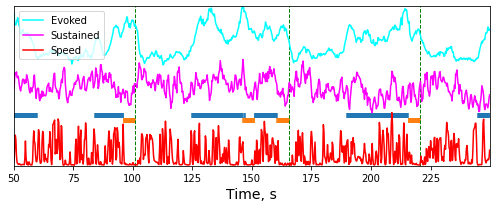

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

ax.plot(x_vals, 2 + EV/EV.max(), color='cyan', label='Evoked')
ax.plot(x_vals, 1 + (SU + abs(SU.min()))/(SU.max()-SU.min()), color='magenta', label='Sustained')
ax.vlines(x_bgr, 0.9, 1.0, color='tab:blue')
ax.vlines(x_tgt, 0.8, 0.9, color='tab:orange')
ax.vlines(idxs_success, 0, 3, color='green', lw=1, ls='--')
ax.plot(x_vals, speed_ev_f/speed_ev_f.max(), color='red', label='Speed')
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(0, 3)
ax.set_yticks([])
ax.legend(loc='upper left')
ax.set_xlabel('Time, s', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_mutual_EV_SU_speed_example.png' % session[-19:-6]), dpi=300)

## Behavioral dynamics

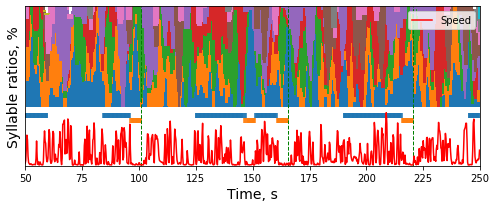

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))


# syllable ratios
idxs_to_idxs = np.where((tl[idxs_srm_tl][:, 0] > t1) & (tl[idxs_srm_tl][:, 0] < t2))[0]
idxs_sel = idxs_srm_tl[idxs_to_idxs]
bottom = np.zeros(len(idxs_sel)) + 1.1
for i, syl_ratio in enumerate(syl_ratio_mx[idxs_to_idxs].T):
    ax.bar(tl[idxs_sel][:, 0] + step, 2*syl_ratio, 1, bottom=bottom)  # , label='Syll. # %s' % str(i+1)
    bottom += 2*syl_ratio

# events
ax.vlines(x_bgr, 0.9, 1.0, color='tab:blue')
ax.vlines(x_tgt, 0.8, 0.9, color='tab:orange')
ax.vlines(idxs_success, 0, 3, color='green', lw=1, ls='--')

# speed
ax.plot(x_vals, speed_ev_f/speed_ev_f.max(), color='red', label='Speed')

    
ax.set_ylim(0, 3)
ax.set_xlim(t1, t2)
#ax.set_title('Behavior composition', fontsize=14)
ax.set_ylabel('Syllable ratios, %', fontsize=14)
ax.legend(loc='upper right')
#ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Time, s', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_behavior_comp_example.png' % session[-19:-6]), dpi=300)

## Behavioral profiles